## **Setup**

In [ ]:
!pip install yfinance optuna tensorflow joblib optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback
import time
import os
import joblib
import random
import tensorflow as tf

In [ ]:
# Set seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'

## **Data**

In [ ]:
from datetime import datetime

def get_crypto_data(symbol='BTC-USD', start='2020-01-01'):
    end = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(symbol, start=start, end=end, auto_adjust=False)
    df = df[['Close']].dropna()
    return df

data = get_crypto_data('BTC-USD', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

Price,Close
Ticker,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [ ]:
data.describe()

Price,Close
Ticker,BTC-USD
count,2123.000000
mean,45649.601773
std,30674.501726
min,4970.788086
25%,21396.963867
50%,38483.125000
75%,62835.164062
max,124752.531250


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2123 entries, 2020-01-01 to 2025-10-23
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BTC-USD)  2123 non-null   float64
dtypes: float64(1)
memory usage: 33.2 KB


In [ ]:
# Calculate yearly percentage change
yearly_changes = {}
for year in range(2021, 2026):
    start_of_year = f'{year}-01-01'
    if year == 2025:
        end_of_year = '2025-09-30'
    else:
        end_of_year = f'{year}-12-31'

    # Get the first and last closing price of the year
    try:
        start_price = data.loc[start_of_year]['Close'].iloc[0]
        # Check if the end of the year is in the data, otherwise use the last available date of the year
        if end_of_year in data.index:
            end_price = data.loc[end_of_year]['Close'].iloc[-1]
        else:
            # Find the last available date for the current year within the specified range
            last_date_of_year_in_range = data.loc[str(year)].index.max()
            if pd.to_datetime(end_of_year) <= last_date_of_year_in_range:
                 end_price = data.loc[end_of_year]['Close'].iloc[-1]
            else:
                end_price = data.loc[last_date_of_year_in_range]['Close'].iloc[-1]


        percentage_change = ((end_price - start_price) / start_price) * 100
        yearly_changes[year] = percentage_change
    except KeyError:
        # Handle cases where there is no data for the start of the year
        yearly_changes[year] = "No data for the start of the year"
    except IndexError:
        # Handle cases where there is no data for the year
        yearly_changes[year] = "No data for the full year"


# Print the results
print("Yearly Percentage Price Difference:")
for year, change in yearly_changes.items():
    print(f"{year}: {change:.2f}%" if isinstance(change, float) else f"{year}: {change}")

Yearly Percentage Price Difference:
2021: 57.64%
2022: -65.30%
2023: 154.23%
2024: 111.53%
2025: 20.80%


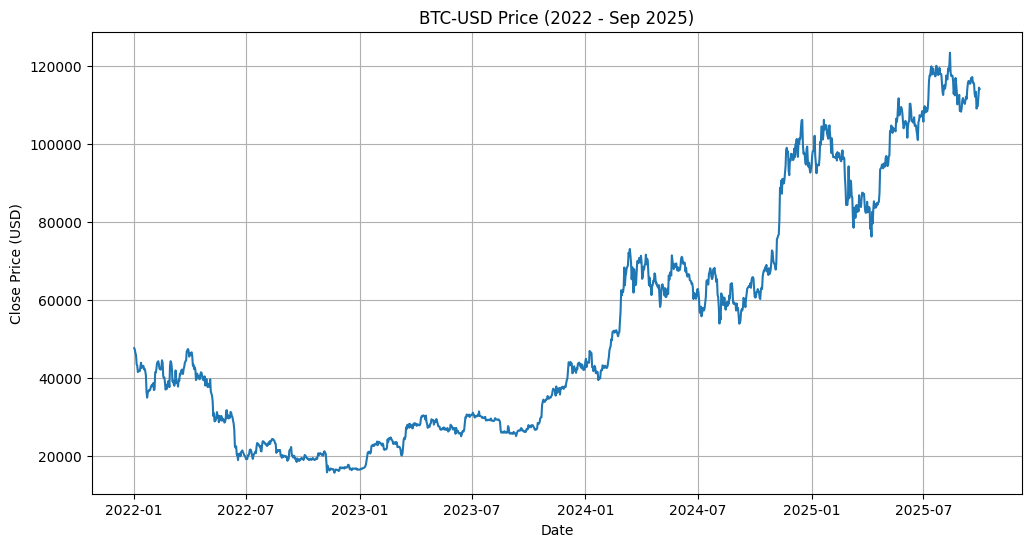

In [ ]:
# Plot price data for the specified period
data_plot = data.loc['2022-01-01':'2025-09-30']

plt.figure(figsize=(12, 6))
plt.plot(data_plot.index, data_plot['Close'])
plt.title('BTC-USD Price (2022 - Sep 2025)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

## **Preprocessing**

In [ ]:
def normalize_series(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)
    return scaled, scaler

def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

## **Rolling Window**

In [ ]:
def rolling_window_split(data, window_size=14):
    folds = [
        ("2022-01-01", "2023-10-31", "2023-11-01", "2023-12-31"),  # Bear Market (2022-2023)
        ("2024-01-01", "2025-07-31", "2025-08-01", "2025-09-30")   # Bull Market (2024-2025)
    ]
    splits = []
    for t_start, t_end, te_start, te_end in folds:
        if pd.to_datetime(te_start) > data.index[-1]:
            continue
        train = data.loc[t_start:t_end]
        test = data.loc[te_start:te_end]
        if len(train) == 0 or len(test) == 0:
            continue
        train_scaled, scaler = normalize_series(train)
        test_scaled = scaler.transform(test)
        X_train, y_train = create_sequences(train_scaled, window_size)
        X_test, y_test = create_sequences(test_scaled, window_size)
        splits.append((X_train, y_train, X_test, y_test, scaler, (t_start, t_end, te_start, te_end)))
    return splits

## **Model**

In [ ]:
def build_lstm_model(trial, input_shape):
    model = Sequential()
    model.add(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        activation='relu',
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2]),
        input_shape=input_shape
    ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

def build_bilstm_model(trial, input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        activation='relu',
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    ), input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

def build_cnn_lstm_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

def build_cnn_bilstm_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Bidirectional(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    )))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

## **Metrics**

In [ ]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    da = np.mean((np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten()))).astype(int))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape, da

## **Optuna**

In [ ]:
def optimize_model(X_train_opt, y_train_opt, X_val, y_val, build_fn, n_trials=20):
    def objective(trial):
        # Suggest learning rate (log-uniform is best for LR)
        lr = trial.suggest_categorical("learning_rate", [0.001, 0.01])

        # Build model
        model = build_fn(trial, (X_train_opt.shape[1], X_train_opt.shape[2]))

        # Compile with tuned learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='mean_squared_error'
        )

        es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
        model.fit(
            X_train_opt, y_train_opt,
            validation_data=(X_val, y_val),
            epochs=trial.suggest_categorical("epochs", [100, 200]),
            batch_size=trial.suggest_categorical("batch_size", [32, 64]),
            verbose=0,
            callbacks=[es, TFKerasPruningCallback(trial, "val_loss")]
        )
        val_pred = model.predict(X_val, verbose=0)
        return mean_squared_error(y_val, val_pred)

    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

## **Pipeline**

In [ ]:
def run_experiment(window_size, n_trials=20):
    print(f"\n{'='*70}")
    print(f" RUNNING EXPERIMENT: WINDOW SIZE = {window_size} ")
    print(f"{'='*70}")

    # Create splits for this window size
    splits = rolling_window_split(data, window_size)
    if not splits:
        print("  → No valid splits. Skipping.")
        return None, None

    model_builders = {
        'LSTM': build_lstm_model,
        'BiLSTM': build_bilstm_model,
        'CNN-LSTM': build_cnn_lstm_model,
        'CNN-BiLSTM': build_cnn_bilstm_model
    }

    results = {}
    timing_results = {}
    VAL_DAYS = 60  # Keep validation consistent

    for model_name, builder in model_builders.items():
        results[model_name] = []
        timing_results[model_name] = []

        for fold_idx, (X_train, y_train, X_test, y_test, scaler, dates) in enumerate(splits):
            t_start, t_end, te_start, te_end = dates
            print(f"[{model_name}] Fold {fold_idx+1} | Win={window_size}")

            if len(X_train) <= VAL_DAYS:
                print(f"  → Skip: not enough data ({len(X_train)})")
                continue

            # Temporal validation
            X_train_opt = X_train[:-VAL_DAYS]
            y_train_opt = y_train[:-VAL_DAYS]
            X_val = X_train[-VAL_DAYS:]
            y_val = y_train[-VAL_DAYS:]

            # Optuna tuning
            study = optimize_model(X_train_opt, y_train_opt, X_val, y_val, builder, n_trials=n_trials)

            # Retrain best model
            best_model = builder(study.best_trial, (X_train.shape[1], X_train.shape[2]))
            best_lr = study.best_trial.params.get("learning_rate", 0.001)
            best_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                loss='mean_squared_error'
            )
            best_model.fit(
              X_train, y_train,
              epochs=study.best_trial.params['epochs'],
              batch_size=study.best_trial.params['batch_size'],
              verbose=0
            )

            # Predict & evaluate
            pred = best_model.predict(X_test, verbose=0)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            pred_inv = scaler.inverse_transform(pred)
            mae, rmse, mape, da = calculate_metrics(y_test_inv, pred_inv)

            # Save model & scaler with window size
            model_path = f"{model_name}_fold_{fold_idx+1}_win{window_size}.keras"
            scaler_path = f"{model_name}_fold_{fold_idx+1}_win{window_size}_scaler.pkl"
            best_model.save(model_path)
            joblib.dump(scaler, scaler_path)

            # Store results (including predictions for plotting)
            test_dates = data.loc[te_start:te_end].index[window_size:]
            results[model_name].append({
                'Window_Size': window_size,
                'Fold': fold_idx + 1,
                'Test_Dates': test_dates,
                'Actual': y_test_inv,
                'Predictions': pred_inv,
                'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'DA': da,
                'Best Params': study.best_trial.params
            })

    return results, splits

In [ ]:
window_sizes = [7, 14]  # Add more if needed
all_results = {}

for ws in window_sizes:
    results, splits = run_experiment(window_size=ws, n_trials=20)  # Reduce trials for speed
    if results:
        all_results[ws] = results

# Save all results to disk (optional but recommended)
import pickle
with open('window_size_experiment_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

[I 2025-10-25 05:47:20,207] A new study created in memory with name: no-name-5230be4d-488a-474a-b1b9-b9368d64aa07



 RUNNING EXPERIMENT: WINDOW SIZE = 7 
[LSTM] Fold 1 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:31,376] Trial 0 finished with value: 0.0028080210817535652 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0028080210817535652.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:35,793] Trial 1 finished with value: 0.004849004274267391 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0028080210817535652.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:39,951] Trial 2 finished with value: 0.004055228607903871 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0028080210817535652.
[I 2025-10-25 05:47:44,406] Trial 3 finished with value: 0.0026255983056035635 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0026255983056035635.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:49,256] Trial 4 finished with value: 0.0028504682058291832 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.0026255983056035635.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:52,405] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:47:56,448] Trial 6 finished with value: 0.0025110626568128854 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 6 with value: 0.0025110626568128854.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:47:59,336] Trial 7 pruned. Trial was pruned at epoch 3.
[I 2025-10-25 05:48:05,878] Trial 8 finished with value: 0.00191149305915306 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 8 with value: 0.00191149305915306.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:09,642] Trial 9 finished with value: 0.0026040074354058557 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 8 with value: 0.00191149305915306.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:12,377] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 05:48:19,167] Trial 11 finished with value: 0.0015073431326189971 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:23,134] Trial 12 finished with value: 0.0036405246737086674 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:28,282] Trial 13 finished with value: 0.0032798323328682693 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:32,888] Trial 14 pruned. Trial was pruned at epoch 8.
[I 2025-10-25 05:48:36,703] Trial 15 finished with value: 0.0021799820537853174 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:41,473] Trial 16 finished with value: 0.0018988594534111555 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:43,996] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:48:48,713] Trial 18 finished with value: 0.0025821363449980523 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 11 with value: 0.0015073431326189971.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:48:51,940] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 05:49:24,531] A new study created in memory with name: no-name-6ed12e6e-3dae-444a-99f3-b8055dd56499


[LSTM] Fold 2 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:29,424] Trial 0 finished with value: 0.01882969069552154 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.01882969069552154.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:33,370] Trial 1 finished with value: 0.013438863523570072 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.013438863523570072.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:37,495] Trial 2 finished with value: 0.027214493801861694 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.013438863523570072.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:43,614] Trial 3 finished with value: 0.025635223044728508 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.013438863523570072.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:47,999] Trial 4 finished with value: 0.004029321618789044 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 4 with value: 0.004029321618789044.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:55,034] Trial 5 finished with value: 0.0018092396985339091 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0018092396985339091.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:49:57,607] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:50:00,205] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 05:50:02,657] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:50:05,098] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:50:10,470] Trial 10 finished with value: 0.0016993806793512564 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 10 with value: 0.0016993806793512564.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:50:14,063] Trial 11 pruned. Trial was pruned at epoch 7.
[I 2025-10-25 05:50:18,474] Trial 12 finished with value: 0.00249888880644959 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 10 with value: 0.0016993806793512564.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:50:21,531] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:50:25,113] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:50:27,961] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 05:50:30,826] Trial 16 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 05:50:35,537] Trial 17 finished with value: 0.0015742908801190572 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 17 with value: 0.0015742908801190572.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:50:39,881] Trial 18 finished with value: 0.002386592891632375 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 17 with value: 0.0015742908801190572.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:50:42,345] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 05:51:13,246] A new study created in memory with name: no-name-3e4b848c-08b2-475e-ac74-a5f8e88ba00d


[BiLSTM] Fold 1 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:18,860] Trial 0 finished with value: 0.003678410734737331 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.003678410734737331.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:26,274] Trial 1 finished with value: 0.0021651955955828916 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0021651955955828916.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:33,791] Trial 2 finished with value: 0.004623955505936088 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0021651955955828916.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:40,618] Trial 3 finished with value: 0.0030605450041096757 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0021651955955828916.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:46,881] Trial 4 finished with value: 0.001774984420381919 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 4 with value: 0.001774984420381919.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:51:55,170] Trial 5 finished with value: 0.0012444764840395725 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 5 with value: 0.0012444764840395725.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:52:01,740] Trial 6 finished with value: 0.001904111168937165 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 5 with value: 0.0012444764840395725.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:52:05,779] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:09,831] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:16,604] Trial 9 finished with value: 0.002985481197984836 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0012444764840395725.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:52:22,949] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:27,653] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:31,743] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:36,191] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:40,650] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:46,590] Trial 15 pruned. Trial was pruned at epoch 14.
[I 2025-10-25 05:52:51,227] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:55,252] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:52:59,191] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:53:03,865] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 05:53:22,474] A new study created in memory with name: no-name-9e8311b7-3d80-49a4-a946-1bc7a07f55bb


[BiLSTM] Fold 2 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:53:30,923] Trial 0 finished with value: 0.00503791164528975 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00503791164528975.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:53:36,911] Trial 1 finished with value: 0.008847697688038409 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00503791164528975.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:53:43,657] Trial 2 finished with value: 0.011436033832049693 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00503791164528975.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:53:49,950] Trial 3 finished with value: 0.01611750708452396 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00503791164528975.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:53:58,460] Trial 4 finished with value: 0.001781638213553925 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 4 with value: 0.001781638213553925.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 05:54:02,842] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:07,396] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:11,431] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:15,894] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:20,580] Trial 9 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 05:54:24,597] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:31,281] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:35,426] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:39,798] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:44,332] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:48,328] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:52,807] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:54:57,118] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:55:01,931] Trial 18 pruned

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-10-25 05:55:45,332] A new study created in memory with name: no-name-dba06182-af71-4b42-8b63-bc0cdb4f5e6c


[CNN-LSTM] Fold 1 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:55:49,969] Trial 0 finished with value: 0.0011929907812823287 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0011929907812823287.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:55:56,266] Trial 1 finished with value: 0.0007318648038735153 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0007318648038735153.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:01,723] Trial 2 finished with value: 0.0009773287411582684 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0007318648038735153.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:06,832] Trial 3 finished with value: 0.0013476685506435626 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0007318648038735153.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:13,628] Trial 4 finished with value: 0.001013051758190832 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0007318648038735153.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:25,570] Trial 5 finished with value: 0.0005153069781638864 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0005153069781638864.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:28,810] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:56:32,935] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:56:36,027] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:56:39,104] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:56:45,876] Trial 10 finished with value: 0.0008177677950210824 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0005153069781638864.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:50,387] Trial 11 finished with value: 0.0008871909408049305 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0005153069781638864.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:56:53,418] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:57:00,397] Trial 13 finished with value: 0.0003941227931300026 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 13 with value: 0.0003941227931300026.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:03,390] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:57:06,439] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:57:11,888] Trial 16 finished with value: 0.0007383175793427816 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 13 with value: 0.0003941227931300026.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:16,612] Trial 17 finished with value: 0.0009994798236422039 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 13 with value: 0.0003941227931300026.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:24,468] Trial 18 finished with value: 0.00039746349371945586 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 13 with value: 0.0003941227931300026.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:27,423] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 05:57:45,429] A new study created in memory with name: no-name-5a2d1ccd-f603-412a-8944-c79da09c3d43


[CNN-LSTM] Fold 2 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:50,302] Trial 0 finished with value: 0.0021044046448065222 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0021044046448065222.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:54,645] Trial 1 finished with value: 0.002536205524828831 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0021044046448065222.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:57:59,937] Trial 2 finished with value: 0.0011901565801039626 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0011901565801039626.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:58:04,690] Trial 3 finished with value: 0.0024699721644566336 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0011901565801039626.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:58:09,251] Trial 4 finished with value: 0.0011042006067569596 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.0011042006067569596.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:58:13,087] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:19,295] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:22,480] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:26,390] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:29,559] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:32,781] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:38,495] Trial 11 finished with value: 0.0010370650101788124 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.0010370650101788124.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:58:41,584] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:44,609] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:47,627] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:51,385] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:54,411] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:58:57,448] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:59:00,530] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 05:59:05,770] Trial 19 finished with value: 0.0016388844875815808 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.0010370650101788124.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-10-25 05:59:21,988] A new study created in memory with name: no-name-9d54712d-d614-4415-8f4f-692b2430c9eb


[CNN-BiLSTM] Fold 1 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:59:37,500] Trial 0 finished with value: 0.00044472897995408844 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:59:45,289] Trial 1 finished with value: 0.0016210625469400915 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 05:59:53,483] Trial 2 finished with value: 0.0011937362768050133 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:00:00,711] Trial 3 finished with value: 0.0017741699143599863 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:00:08,103] Trial 4 finished with value: 0.0017775611147515242 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:00:13,115] Trial 5 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:00:22,926] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:00:31,736] Trial 7 finished with value: 0.0015078449663315078 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:00:36,692] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:00:44,873] Trial 9 finished with value: 0.001194954360869302 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.00044472897995408844.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:00:49,964] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:00:55,592] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:00,307] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:06,182] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:11,357] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:16,106] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:21,527] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:26,262] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:01:32,278] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:01:36,952] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 06:02:04,657] A new study created in memory with name: no-name-18e51a20-1bb8-47be-a070-ce503b2a5fbd


[CNN-BiLSTM] Fold 2 | Win=7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:12,138] Trial 0 finished with value: 0.0019838926393949906 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0019838926393949906.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:20,096] Trial 1 finished with value: 0.0012215842117537753 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0012215842117537753.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:27,715] Trial 2 finished with value: 0.0015180308146692796 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0012215842117537753.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:35,428] Trial 3 finished with value: 0.0011171008041451535 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0011171008041451535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:48,137] Trial 4 finished with value: 0.0012498783123035865 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0011171008041451535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:02:53,991] Trial 5 pruned. Trial was pruned at epoch 4.
[I 2025-10-25 06:03:02,620] Trial 6 finished with value: 0.001457369194202998 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0011171008041451535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:03:07,728] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:03:13,404] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:03:18,229] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:03:26,092] Trial 10 finished with value: 0.0011743539658135042 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 3 with value: 0.0011171008041451535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:03:32,952] Trial 11 finished with value: 0.00108194440111042 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:03:40,488] Trial 12 finished with value: 0.0011906312679300095 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:03:47,899] Trial 13 finished with value: 0.0011529170695769471 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:03:52,957] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:03:57,728] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:04:06,799] Trial 16 finished with value: 0.0011855931943293653 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:04:14,829] Trial 17 finished with value: 0.0011149833002516468 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:04:19,712] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:04:27,751] Trial 19 finished with value: 0.0011264508773080682 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 11 with value: 0.00108194440111042.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-10-25 06:04:48,987] A new study created in memory with name: no-name-b72b1ce2-3f85-4975-b4ae-b3725f41575d



 RUNNING EXPERIMENT: WINDOW SIZE = 14 
[LSTM] Fold 1 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:04:53,711] Trial 0 finished with value: 0.004373077112678785 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.004373077112678785.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:04:57,878] Trial 1 finished with value: 0.004246444614366737 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.004246444614366737.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:04,244] Trial 2 finished with value: 0.005265293288953856 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.004246444614366737.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:08,110] Trial 3 finished with value: 0.002944930689078077 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 3 with value: 0.002944930689078077.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:12,229] Trial 4 finished with value: 0.008886459970967785 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.002944930689078077.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:15,188] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:05:18,140] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:05:22,160] Trial 7 finished with value: 0.0034360810314017815 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.002944930689078077.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:24,677] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:05:27,635] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:05:30,602] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:05:39,292] Trial 11 pruned. Trial was pruned at epoch 4.
[I 2025-10-25 06:05:46,905] Trial 12 finished with value: 0.005638685901145033 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.002944930689078077.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:53,625] Trial 13 finished with value: 0.0019285268511912714 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 13 with value: 0.0019285268511912714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:05:58,592] Trial 14 finished with value: 0.003287981787782664 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 13 with value: 0.0019285268511912714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:06:01,547] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:06:06,544] Trial 16 finished with value: 0.0029857507313197453 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 13 with value: 0.0019285268511912714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:06:09,803] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:06:12,715] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:06:15,550] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 06:06:46,952] A new study created in memory with name: no-name-89cb8dc3-e73a-4eb1-92c9-866a14118a2c


[LSTM] Fold 2 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:06:52,478] Trial 0 finished with value: 0.007617851499738956 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.007617851499738956.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:06:58,053] Trial 1 finished with value: 0.003224055480151649 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:02,926] Trial 2 finished with value: 0.007910132623916459 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:09,786] Trial 3 finished with value: 0.03314888119811947 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:15,651] Trial 4 finished with value: 0.015364731761018364 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:18,506] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:07:24,065] Trial 6 finished with value: 0.005449560445155977 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:26,725] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:07:29,578] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:07:34,667] Trial 9 finished with value: 0.006959796628208542 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.003224055480151649.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:07:37,390] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:07:40,245] Trial 11 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:07:43,011] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:07:46,206] Trial 13 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:07:49,267] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:07:52,091] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:07:54,708] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:07:57,501] Trial 17 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:08:01,020] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:08:03,759] Trial 19 pruned. Trial was pruned at epoch 1.


[I 2025-10-25 06:08:36,212] A new study created in memory with name: no-name-050152f9-8c5e-4012-9b61-cd9840cd4326


[BiLSTM] Fold 1 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:08:43,329] Trial 0 finished with value: 0.00418953902891283 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00418953902891283.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:08:50,512] Trial 1 finished with value: 0.003788261178123943 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.003788261178123943.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:08:57,494] Trial 2 finished with value: 0.005505506733477448 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.003788261178123943.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:09:05,352] Trial 3 finished with value: 0.003261849842504483 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.003261849842504483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:09:11,491] Trial 4 finished with value: 0.004461450032554751 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 3 with value: 0.003261849842504483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:09:16,380] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:09:20,825] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:09:25,126] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:09:30,858] Trial 8 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:09:35,038] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:09:39,386] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:09:46,835] Trial 11 finished with value: 0.0047318558181842305 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.003261849842504483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:10:00,808] Trial 12 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:10:10,286] Trial 13 finished with value: 0.004484969445808738 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.003261849842504483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:10:17,487] Trial 14 finished with value: 0.004711469708698071 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.003261849842504483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:10:22,844] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:10:27,424] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:10:32,752] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:10:37,328] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:10:41,721] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 06:11:52,666] A new study created in memory with name: no-name-e9407d88-d863-4405-b9c4-95e609df7c21


[BiLSTM] Fold 2 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:01,938] Trial 0 finished with value: 0.002475403510369023 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.002475403510369023.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:08,598] Trial 1 finished with value: 0.002023369484569253 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.002023369484569253.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:16,006] Trial 2 finished with value: 0.0016847801774472091 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.0016847801774472091.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:22,216] Trial 3 finished with value: 0.008959333852617494 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.0016847801774472091.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:29,838] Trial 4 finished with value: 0.019532519937545526 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.0016847801774472091.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:33,832] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:12:38,912] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:12:45,533] Trial 7 finished with value: 0.0015830266129473309 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 7 with value: 0.0015830266129473309.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:12:50,657] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:12:54,777] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:13:01,931] Trial 10 finished with value: 0.002259103878838158 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 7 with value: 0.0015830266129473309.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:08,707] Trial 11 finished with value: 0.00412430869731532 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 7 with value: 0.0015830266129473309.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:16,098] Trial 12 finished with value: 0.002142112009348121 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 7 with value: 0.0015830266129473309.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:22,386] Trial 13 finished with value: 0.0016746213076564577 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 7 with value: 0.0015830266129473309.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:30,200] Trial 14 finished with value: 0.0015354707256878914 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 14 with value: 0.0015354707256878914.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:34,701] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:13:42,439] Trial 16 finished with value: 0.0031341404194194324 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 14 with value: 0.0015354707256878914.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-25 06:13:47,191] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:13:56,271] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:14:00,795] Trial 19 pruned. Trial was pruned at epoch 1.


[I 2025-10-25 06:14:36,213] A new study created in memory with name: no-name-dd2e8c8f-2458-404d-a50a-59fef717806e


[CNN-LSTM] Fold 1 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:14:41,157] Trial 0 finished with value: 0.0020427299550781447 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0020427299550781447.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:14:50,747] Trial 1 finished with value: 0.0004174480355055474 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:14:59,610] Trial 2 finished with value: 0.0012206925454820341 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:15:04,944] Trial 3 finished with value: 0.002440028625937074 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:15:11,053] Trial 4 finished with value: 0.0016979241928327569 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:15:14,332] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:15:19,636] Trial 6 finished with value: 0.0021769311172366427 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:15:24,070] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:15:36,557] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:15:40,240] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:15:43,898] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:15:48,090] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:15:51,648] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:15:56,859] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:16:03,663] Trial 14 finished with value: 0.001130180114604275 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:16:07,254] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:16:14,752] Trial 16 finished with value: 0.0011730030233155107 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0004174480355055474.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:16:22,990] Trial 17 finished with value: 0.00038599834126468413 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 17 with value: 0.00038599834126468413.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:16:31,191] Trial 18 finished with value: 0.00046203973962973563 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 17 with value: 0.00038599834126468413.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:16:35,512] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 06:17:07,342] A new study created in memory with name: no-name-3573adb6-f26b-4eaa-af79-b01c9a9bc8f0


[CNN-LSTM] Fold 2 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:12,835] Trial 0 finished with value: 0.0027432051167583225 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0027432051167583225.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:19,054] Trial 1 finished with value: 0.004478163196961172 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0027432051167583225.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:24,897] Trial 2 finished with value: 0.003065091095325654 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0027432051167583225.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:31,903] Trial 3 finished with value: 0.00590961941976009 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0027432051167583225.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:37,130] Trial 4 finished with value: 0.0017020440127249721 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 4 with value: 0.0017020440127249721.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:44,109] Trial 5 finished with value: 0.0014992273799380247 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:17:47,919] Trial 6 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:17:51,337] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:17:57,050] Trial 8 finished with value: 0.0026735085121133845 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:18:00,740] Trial 9 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:18:04,112] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:18:08,143] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:18:11,445] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:18:14,732] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:18:18,458] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:18:24,008] Trial 15 finished with value: 0.0016192597551872058 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:18:29,009] Trial 16 finished with value: 0.0024806363751710614 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:18:34,852] Trial 17 finished with value: 0.0020240802925290324 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:18:39,742] Trial 18 finished with value: 0.0016207012985539565 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0014992273799380247.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:18:46,885] Trial 19 finished with value: 0.0012059403353243017 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 19 with value: 0.0012059403353243017.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-10-25 06:19:22,918] A new study created in memory with name: no-name-d3271a7c-61aa-465d-9c29-0efcf9690b05


[CNN-BiLSTM] Fold 1 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:19:30,964] Trial 0 finished with value: 0.0032261843411174967 and parameters: {'learning_rate': 0.001, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0032261843411174967.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:19:40,450] Trial 1 finished with value: 0.002899758147818795 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.002899758147818795.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:19:49,994] Trial 2 finished with value: 0.0024695833105249933 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.0024695833105249933.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:20:00,509] Trial 3 finished with value: 0.0005463680202160439 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.0005463680202160439.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:20:13,554] Trial 4 finished with value: 0.00042413537806773317 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:20:18,899] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:20:24,603] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:20:30,241] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:20:37,946] Trial 8 finished with value: 0.0028107452818360804 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:20:43,321] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:20:48,387] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:20:59,455] Trial 11 finished with value: 0.0004250486201656507 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:21:05,350] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:21:12,743] Trial 13 finished with value: 0.0021985311073798998 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:21:18,617] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:21:37,773] Trial 15 finished with value: 0.0027299559166643708 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:21:50,980] Trial 16 finished with value: 0.0004595316397460846 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.00042413537806773317.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:21:57,530] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:22:03,963] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:22:11,060] Trial 19 pruned. Trial was pruned at epoch 0.


[I 2025-10-25 06:22:55,277] A new study created in memory with name: no-name-063bb4af-7e58-4b84-9a18-68a77b96cbca


[CNN-BiLSTM] Fold 2 | Win=14


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:11,861] Trial 0 finished with value: 0.0008698054770814909 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:20,285] Trial 1 finished with value: 0.0037216483616333068 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:28,428] Trial 2 finished with value: 0.0022758751870975468 and parameters: {'learning_rate': 0.01, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:37,721] Trial 3 finished with value: 0.001725070940256612 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:45,597] Trial 4 finished with value: 0.004269957225900423 and parameters: {'learning_rate': 0.01, 'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:23:52,064] Trial 5 pruned. Trial was pruned at epoch 2.
[I 2025-10-25 06:23:57,181] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:03,029] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:08,651] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:24:14,339] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:19,247] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:24,549] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:30,011] Trial 12 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:35,264] Trial 13 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:24:40,998] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2025-10-25 06:24:48,642] Trial 15 finished with value: 0.0023108875274524374 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:24:58,360] Trial 16 finished with value: 0.0020366103008856175 and parameters: {'learning_rate': 0.001, 'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0008698054770814909.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-25 06:25:04,689] Trial 17 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:25:09,802] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2025-10-25 06:25:14,993] Trial 19 pruned. Trial was pruned at epoch 0.


## **Comparison**

In [ ]:
# Get model evaluation
model_evaluation = []
for ws, results in all_results.items():
    for model_name, folds in results.items():
        for fold_idx, fold_results in enumerate(folds):
            model_evaluation.append({
                'Window_Size': ws,
                'Model': model_name,
                'Fold': fold_idx + 1,
                'MAE': fold_results['MAE'],
                'RMSE': fold_results['RMSE'],
                'MAPE': fold_results['MAPE'],
                'DA': fold_results['DA']
            })

df_eval = pd.DataFrame(model_evaluation)
print(df_eval)

    Window_Size       Model  Fold          MAE         RMSE      MAPE  \
0             7        LSTM     1  2320.811777  2512.904789  5.716491   
1             7        LSTM     2  8343.290654  8535.441367  7.306297   
2             7      BiLSTM     1  2672.863281  2837.523189  6.602629   
3             7      BiLSTM     2  7549.501157  7758.152223  6.607680   
4             7    CNN-LSTM     1  1464.002315  1658.433906  3.606761   
5             7    CNN-LSTM     2  2038.100116  2395.240271  1.777238   
6             7  CNN-BiLSTM     1   788.013889  1034.226144  1.937408   
7             7  CNN-BiLSTM     2  4683.130787  5062.460334  4.085385   
8            14        LSTM     1  2487.324801  2660.842361  6.063616   
9            14        LSTM     2  7539.586769  7742.392485  6.650362   
10           14      BiLSTM     1  3253.102560  3388.272680  7.944028   
11           14      BiLSTM     2  6474.092088  6678.428961  5.706659   
12           14    CNN-LSTM     1  1657.367104  183

In [ ]:
# Get model best paramas
model_params = []
for ws, results in all_results.items():
    for model_name, folds in results.items():
        for fold_idx, fold_results in enumerate(folds):
            model_params.append({
                'Window_Size': ws,
                'Model': model_name,
                'Fold': fold_idx + 1,
                'Best Params': fold_results['Best Params']
            })

df_params = pd.DataFrame(model_params)
print(df_params)

    Window_Size       Model  Fold  \
0             7        LSTM     1   
1             7        LSTM     2   
2             7      BiLSTM     1   
3             7      BiLSTM     2   
4             7    CNN-LSTM     1   
5             7    CNN-LSTM     2   
6             7  CNN-BiLSTM     1   
7             7  CNN-BiLSTM     2   
8            14        LSTM     1   
9            14        LSTM     2   
10           14      BiLSTM     1   
11           14      BiLSTM     2   
12           14    CNN-LSTM     1   
13           14    CNN-LSTM     2   
14           14  CNN-BiLSTM     1   
15           14  CNN-BiLSTM     2   

                                          Best Params  
0   {'learning_rate': 0.01, 'units': 64, 'dropout'...  
1   {'learning_rate': 0.01, 'units': 64, 'dropout'...  
2   {'learning_rate': 0.01, 'units': 64, 'dropout'...  
3   {'learning_rate': 0.01, 'units': 32, 'dropout'...  
4   {'learning_rate': 0.01, 'units': 32, 'dropout'...  
5   {'learning_rate': 0.01, 'units

In [ ]:
# Check detail params
df_params['Best Params'].iloc[0]

{'learning_rate': 0.01,
 'units': 64,
 'dropout': 0.1,
 'epochs': 200,
 'batch_size': 32}

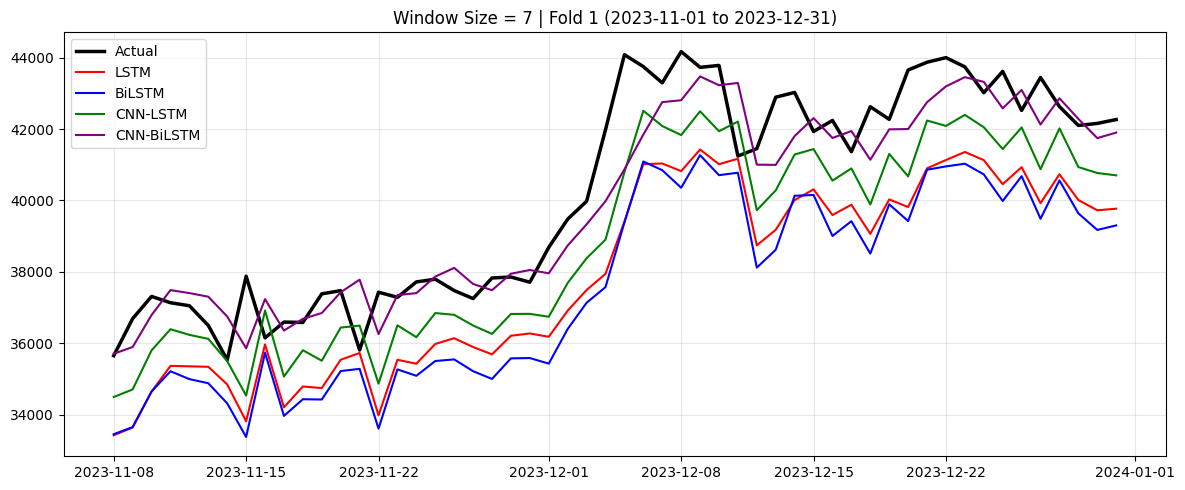

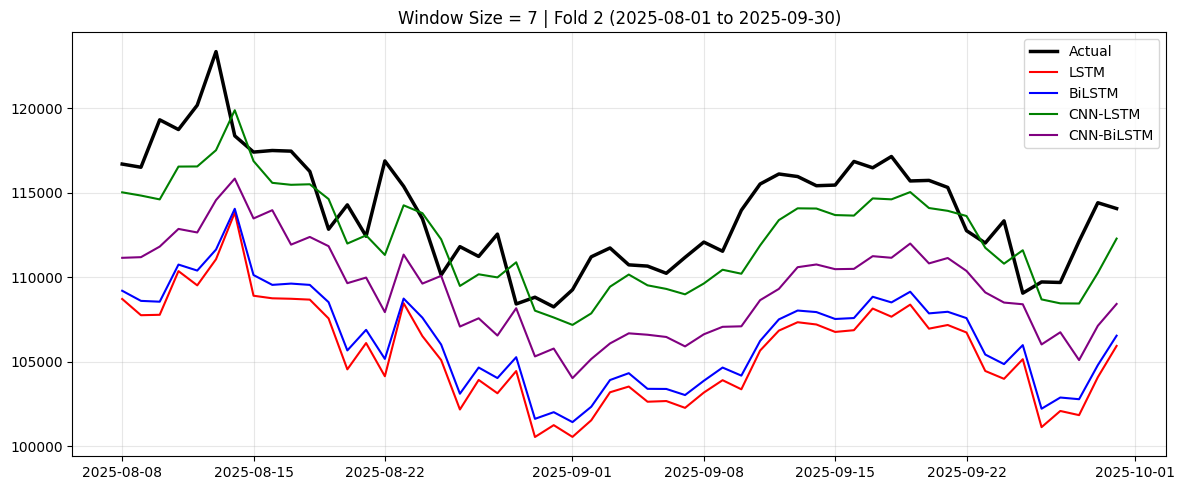

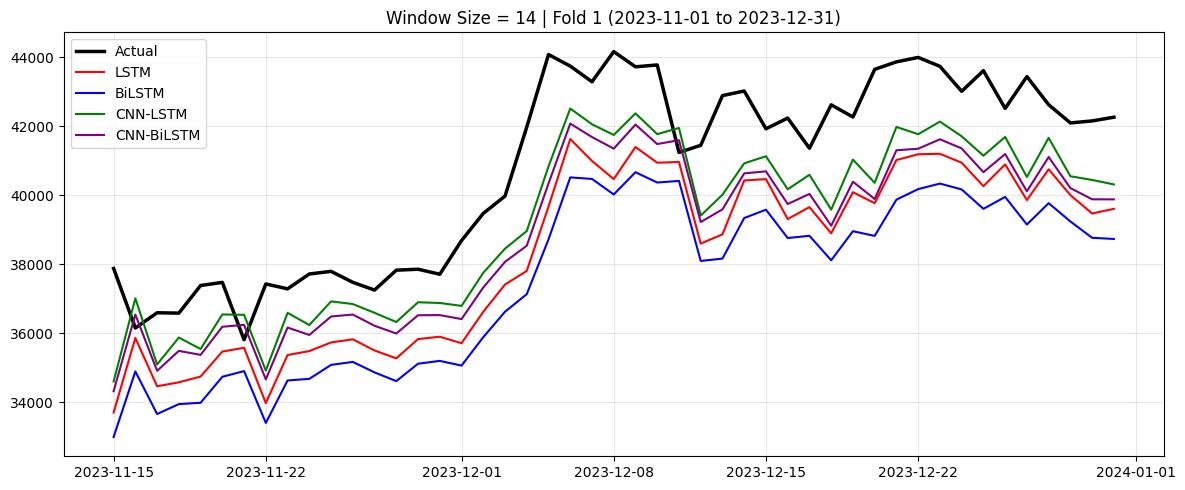

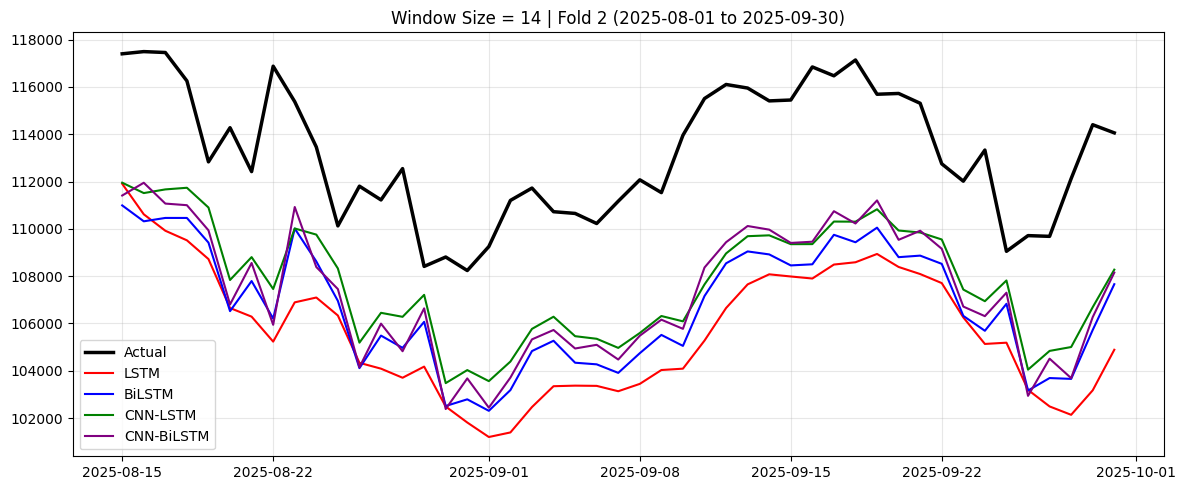

In [ ]:
# Plot actual vs predictions for each window size
for ws, results in all_results.items():
    splits_ws = rolling_window_split(data, ws)  # Re-generate splits for dates
    for fold_idx in range(len(splits_ws)):
        _, _, _, _, _, dates = splits_ws[fold_idx]
        _, _, te_start, te_end = dates

        plt.figure(figsize=(12, 5))
        # Actual prices
        y_actual = data.loc[te_start:te_end]['Close'].values[ws:]
        test_dates = data.loc[te_start:te_end].index[ws:]
        plt.plot(test_dates, y_actual, 'k-', linewidth=2.5, label='Actual')

        colors = {'LSTM': 'red', 'BiLSTM': 'blue', 'CNN-LSTM': 'green', 'CNN-BiLSTM': 'purple'}
        for model_name in results.keys():
            if fold_idx < len(results[model_name]):
                pred = results[model_name][fold_idx]['Predictions']
                plt.plot(test_dates, pred, color=colors[model_name], label=model_name)

        plt.title(f'Window Size = {ws} | Fold {fold_idx+1} ({te_start} to {te_end})')
        plt.legend(); plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()